<a href="https://colab.research.google.com/github/thisarawelmilla/SimpleWebApplication/blob/master/Ride_fare_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime

from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, mean_absolute_error, roc_curve, roc_auc_score
from sklearn.datasets import make_regression
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout,BatchNormalization
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor, LGBMClassifier

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
def histogram (feature, bins, ranges, labels):
  for i in range(len(feature)):
    pyplot.hist(feature[i], bins[i], range=(0, ranges), alpha=0.5, label=labels[i])
  pyplot.legend(loc='upper right')
  pyplot.show()

In [ ]:
col_names = list(prepoccessed_df.columns)
incorrect = prepoccessed_df[prepoccessed_df['label']=='incorrect']
correct = prepoccessed_df[prepoccessed_df['label']=='correct']
for i in col_names:
  try:
    max_val = prepoccessed_df[i].idxmax()
    histogram ([incorrect[i], correct[i]],[100, 100],  max_val, [i+'-incorrect', i+'-correct'])
  except:
    print('cannot show histrogram for '+ i)

# PREPROCESSING 

In [ ]:
mdef date_time(col_name):
  hour =[]
  date = []
  
  for i in df[col_name]:
    date_time = i.split(" ")
    get_date = date_time[0].split("/")
    get_time = date_time[1].split(":")
    hour.append(int(get_time[0])+int(get_time[1])/60.0)
    try: 
      d0 = datetime(int(get_date[2]), int(get_date[1]), int(get_date[0]), int(get_time[0]), int(get_time[1]), 0)
    except ValueError:
      d0 = datetime(int(get_date[2]), int(get_date[0]), int(get_date[1]), int(get_time[0]), int(get_time[1]), 0)
    day =d0.weekday()
    date.append(day)

  return hour, date


In [ ]:
def get_all_riding_hours(pickup_hour, drop_hour):
  riding_hours = []
  n=0
  for i in pickup_hour:
    d = int(drop_hour[n])
    count = int(i)
    q =[]
    if d > int(i):
      while count <= d:
        q.append(count)
        count +=1
    elif d == int(i):
        q.append(count)
    else:
      while count <25:
        q.append(count)
        count +=1
      while count <= d:
        q.append(count)
        count +=1
    riding_hours.append(q)
    n+=1
    return riding_hours

In [ ]:
def feature_transform(df):
  pick_lat = df['pick_lat'].to_numpy()
  pick_lon = df['pick_lon'].to_numpy()
  drop_lat = df['drop_lat'].to_numpy()
  drop_lon = df['drop_lon'].to_numpy()

  distance = ((abs(drop_lat-pick_lat)**2 + abs(drop_lon-pick_lon)**2)**0.5)*1000
  df['distance'] = pd.Series(distance, index = df.index)

  loc_ratio = abs(drop_lat-pick_lat)/abs(drop_lon-pick_lon+0.0000001)
  df['loc_ratio'] = pd.Series(loc_ratio, index = df.index)

  #loc_pick_drop = abs(pick_lat-pick_lon)/abs(drop_lat-drop_lon+0.0000001)
  #df['loc_pick_drop'] = pd.Series(loc_pick_drop, index = df.index)

  duration = df['duration'].to_numpy()
  distance = df['distance'].to_numpy()
  fare = df['fare'].to_numpy()
  meter_waiting = df['meter_waiting'].to_numpy()
  meter_waiting_fare = df['meter_waiting_fare'].to_numpy()
  add_fare = df['additional_fare'].to_numpy()
  
  riding_duration = duration - meter_waiting
  df['riding_duration'] = pd.Series(riding_duration, index = df.index)

  riding_duration_ratio = duration/(riding_duration +0.0000001)
  df['riding_duration_ratio'] = pd.Series(riding_duration_ratio, index = df.index)

  extra_fare = fare - (add_fare + meter_waiting_fare)
  df['fare'] = pd.Series(extra_fare, index = df.index)

  speed = distance /(fare+0.0000001)
  df['fare_rate'] = pd.Series(speed, index = df.index)

  duration = df['riding_duration'].to_numpy()

  fare_rate_for_dur = duration /(fare+0.0000001)
  df['fare_rate_for_dur'] = pd.Series(fare_rate_for_dur, index = df.index)

  waiting_fare_rate = meter_waiting_fare /(meter_waiting+0.0000001)
  df['waiting_fare_rate'] = pd.Series(waiting_fare_rate, index = df.index)

  additional_fare = df['additional_fare'].to_numpy()
  meter_waiting_till_pickup = df['meter_waiting_till_pickup'].to_numpy()

  additional_fare_rate = additional_fare /(meter_waiting_till_pickup+0.0000001)
  df['additional_fare_rate'] = pd.Series(additional_fare_rate, index = df.index)

  additional_per_dur = additional_fare /(duration+0.0000001)
  df['additional_per_dur'] = pd.Series(additional_per_dur, index = df.index)

  additional_per_dis = additional_fare /(distance+0.0000001)
  df['additional_per_dis'] = pd.Series(additional_per_dis, index = df.index)

  dis_per_dur = distance /(duration+0.0000001)
  df['dis_per_dur'] = pd.Series(dis_per_dur, index = df.index)

  waiting_per_dur = meter_waiting /(duration+0.0000001)
  df['waiting_per_dur'] = pd.Series(waiting_per_dur, index = df.index)

  waiting_per_dis = meter_waiting /(distance+0.0000001)
  df['waiting_per_dis'] = pd.Series(waiting_per_dis, index = df.index)

  return df


In [ ]:
def feature_crossing(df, column_list):
    crossed_df = df.copy()
    crossed_df[f'{column_list[0]}_{column_list[1]}'] = crossed_df.agg(lambda x: f"{x[column_list[0]]}_{x[column_list[1]]}", axis=1)
            
    return crossed_df

# SAMPLING

In [ ]:
from sklearn.utils import resample

def sampling(df, upsample, downsample, upsample_ratio, downsample_ratio):
  df_minority = df[df['label']=='incorrect']
  df_majority = df[df['label']=='correct']

  if upsample:
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,   
                                    n_samples=upsample_ratio)
  if downsample:
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,  
                                    n_samples=downsample_ratio)
  print(df_minority_upsampled.shape)
  print(df_majority_downsampled.shape)

  df = pd.concat([df_minority_upsampled, df_majority_downsampled])
  df.label.value_counts()

  return df

# MODELS FOR TRAINING

In [ ]:
from sklearn.preprocessing import LabelEncoder

def prep_for_trainig(df):
  label1 = LabelEncoder()
  df['label'] = label1.fit_transform(df['label'])
  X=df.drop(['label'],axis=1)
  y=df['label']
  X.head()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  return X_train, X_test, y_train, y_test


In [ ]:
def XGBClassification_model( X_train, X_test, y_train, y_test):
  model =  LGBMClassification(n_estimators=1000,learning_rate=0.02,verbose_eval=4) 
  model.fit(X_train,y_train)

  prediction = model.predict(X_test)

  mae = mean_absolute_error(prediction, y_test)
  mse = mean_squared_error(prediction, y_test)
  print('MAE :', mae, 'MSE :', mse)

  return model

In [ ]:
def XGBRegressor_model( X_train, X_test, y_train, y_test):
  model =  LGBMRegressor(n_estimators=1000,learning_rate=0.02,verbose_eval=4) 
  model.fit(X_train,y_train)

  prediction = model.predict(X_test)

  mae = mean_absolute_error(prediction, y_test)
  mse = mean_squared_error(prediction, y_test)
  print('MAE :', mae, 'MSE :', mse)

  return model


In [ ]:
def LGBMClassification_model( X_train, X_test, y_train, y_test):
  model =  LGBMClassification(n_estimators=1000,learning_rate=0.02,verbose_eval=4) 
  model.fit(X_train,y_train)

  prediction = model.predict(X_test)

  mae = mean_absolute_error(prediction, y_test)
  mse = mean_squared_error(prediction, y_test)
  print('MAE :', mae, 'MSE :', mse)

  return model

In [ ]:
def LGBMRegressor_model( X_train, X_test, y_train, y_test):
  model =  LGBMRegressor(n_estimators=1000,learning_rate=0.02,verbose_eval=4) 
  model.fit(X_train,y_train)

  prediction = model.predict(X_test)

  mae = mean_absolute_error(prediction, y_test)
  mse = mean_squared_error(prediction, y_test)
  print('MAE :', mae, 'MSE :', mse)

  return model


# MODEL ESEMBLING

In [ ]:
def init_h2o():
  !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

  import h2o
  from h2o.automl import H2OAutoML
  h2o.init()  


In [ ]:
def h2o_model(X_train, y_train):
  X_train = X_train.join(y_train)
  X_train = h2o.H2OFrame(X_train)
  x = X_train.columns
  y = "label"
  x.remove(y)

  X_train["label"] = X_train["label"]
  model = H2OAutoML(max_models=60, seed=1, max_runtime_secs=3600)

  model.train(x = x, y = y, training_frame = hf)

  model.leaderboard

  return model

In [ ]:
def h2o_val(model, X_test, y_test):
  test = h2o.H2OFrame(X_test)
  prediction = model.leader.predict(test)
  pred = h2o.as_list(prediction)

  print(roc_auc_score(y_test, pred['predict']))

# MODEL VISUALIZATION

In [ ]:
def show_roc(model, data_feature, label):
  pred = model.predict(data_feature)
  roc_auc = roc_auc_score(label, pred)

  roc_fpr, roc_tpr , _ = roc_curve(label, pred)
  pyplot.plot(roc_fpr, roc_tpr, linestyle='--', label='pred')

  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')

  pyplot.legend()
  pyplot.show()

  print('ROC AUC=%.5f' % (roc_auc))

In [ ]:
def feature_important_lightgbm(model):
  lightgbm.plot_importance(model)
  plt.rcParams['figure.figsize'] = [5, 7]
  plt.rcParams['figure.dpi'] = 100
  plt.rcParams['figure.facecolor'] = 'w'
  plt.show()

In [ ]:
def feature_important_xgb(model):
  xgb.plot_importance(model)
  plt.rcParams['figure.figsize'] = [25, 15]
  plt.show()

# TRAINING

In [ ]:
def preprocessing(df):
  pickup_hour, pickup_date = date_time('pickup_time')
  drop_hour, drop_date = date_time('drop_time')

  df['pickup_date'] = pd.Series(np.array(pickup_date), index = df.index)
  df['drop_date'] = pd.Series(np.array(drop_date), index = df.index)
  df['pickup_slot'] = pd.Series(np.array(pickup_hour), index = df.index)
  df['drop_slot'] = pd.Series(np.array(drop_hour), index = df.index)

  #riding_hours = get_all_riding_hours(pickup_hour, drop_hour)
  #df['riding_hours'] = pd.Series(np.array(riding_hours), index = df.index)
  
  df = df.drop('pickup_time', axis = 1)
  df = df.drop('drop_time', axis = 1)
  df = df.drop('tripid', axis = 1)

  df = feature_transform(df)

  #df = feature_crossing(df, ['riding_duration', 'distance'])
  from sklearn.utils import shuffle
  df = shuffle(df)
  df = df[df['fare'].notna()]
  df = df[df['additional_fare'].notna()]

  df = sampling(df, True, True, 7000, 6000)
  
  df = shuffle(df)

  return df

In [ ]:
def training(df):
  
  X_train, X_test, y_train, y_test = prep_for_trainig(df)

  model = LGBMRegressor_model( X_train, X_test, y_train, y_test)
  #model = LGBMClassification_model( X_train, X_test, y_train, y_test)
  #model = XGBClassification_model( X_train, X_test, y_train, y_test)
  #model = XGBRegressor_model( X_train, X_test, y_train, y_test)

  show_roc(model, X_train, y_train)
  show_roc(model, X_test, y_test)

  feature_important_lightgbm(model)
  #feature_important_xgb(model)

  return model

In [ ]:
df = pd.read_csv("/content/drive/My Drive/sem 7/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/sem 7/test.csv")

In [ ]:
df.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup_date,drop_date,pickup_slot,drop_slot
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,4,4,0.333333,0.566667
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,4,4,0.933333,1.150000
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,4,4,1.133333,1.433333
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,4,4,2.450000,2.616667
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct,4,4,3.566667,3.850000


In [ ]:
prepoccessed_df = preprocessing(df)

(7000, 28)
(6000, 28)


In [ ]:
prepoccessed_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup_date,drop_date,pickup_slot,drop_slot,distance,loc_ratio,riding_duration,riding_duration_ratio,fare_rate,fare_rate_for_dur,waiting_fare_rate,additional_fare_rate,additional_per_dur,additional_per_dis,dis_per_dur,waiting_per_dur,waiting_per_dis
12208,10.5,667.0,23.0,0.0000,48.0,7.12515,79.8847,7.16599,79.8847,176.9700,correct,0,0,7.433333,7.616667,40.840000,408400.000000,644.0,1.035714,0.230774,3.639035,0.0000,0.218750,0.016304,0.257101,0.063416,0.035714,0.563173
12614,10.5,2380.0,0.0,0.0000,15.0,6.92156,79.8479,6.92163,79.8479,50.0000,incorrect,5,5,9.683333,10.350000,0.070000,700.000000,2380.0,1.000000,0.001400,47.600000,0.0000,0.700000,0.004412,149.999786,0.000029,0.000000,0.000000
3461,10.5,16663.0,8400.0,485.5200,49.0,6.91258,79.8744,6.91254,79.8746,1037.9400,correct,3,3,9.783333,14.400000,0.203961,0.199900,8263.0,2.016580,0.000197,7.960961,0.0578,0.214286,0.001271,51.480460,0.000025,1.016580,41184.368185
6441,10.5,2103.0,1251.0,72.9333,23.0,6.73239,80.0846,6.73120,80.0811,88.4967,correct,2,2,9.550000,10.133333,3.696769,0.340010,852.0,2.468310,0.041773,9.627478,0.0583,0.456522,0.012324,2.840318,0.004339,1.468310,338.403620
9415,80.5,33.0,22.0,1.2826,6.0,6.83447,79.8764,6.83569,79.8770,49.9974,incorrect,5,5,10.250000,10.266667,1.359559,2.032995,11.0,3.000000,0.027193,0.220011,0.0583,13.416666,7.318182,59.210383,0.123596,2.000000,16.181720


MAE : 0.10638495343075083 MSE : 0.03651098165450793


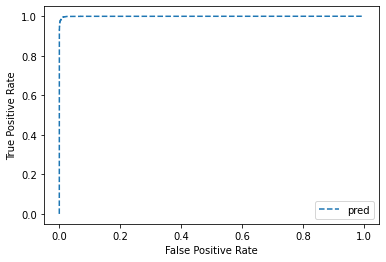

ROC AUC=0.99968


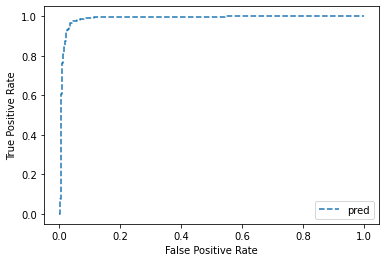

ROC AUC=0.98805


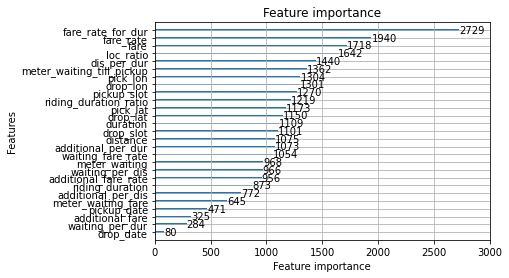

In [ ]:
model = training(prepoccessed_df)

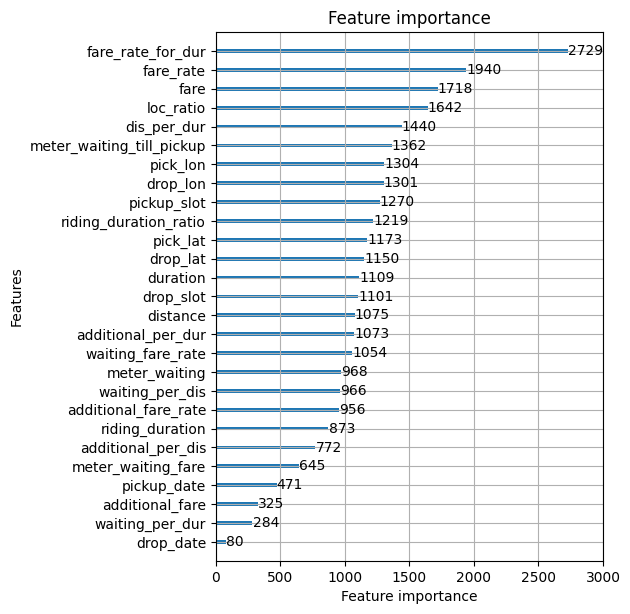

In [ ]:
feature_important_lightgbm(model)

# SUBMISSION

In [ ]:
def testing(model):
    df = pd.read_csv("/content/drive/My Drive/sem 7/test.csv")

    trip_id = df['tripid']
    preprocessing(df)

    y_pred = model.predict(df)
    predictions = [round(value) for value in y_pred]
    '''
    hf_test = h2o.H2OFrame(df)
    pred = xgb_model_1a.leader.predict(hf_test)
    pf = h2o.as_list(pred)
    
    y_pred = pf['predict']
    '''
    l=[]
    n=0
    j=0
    for i in y_pred:
      if i<=0.46:
        l.append(1)
      else:
        l.append(0)
    print(n,j)

    q= trip_id.to_frame()
    q['prediction'] = pd.Series(np.array(l), index = q.index)

    return q, j
  